In [1]:
import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

# Load Functions 

In [2]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def abs_cos_vector1(v1, v2):
    return abs(dotproduct(v1, v2) / length(v2))

def calc_force(df):
    df['force'] = df['Fx']**2 + df['Fy']**2 + df['Fz']**2
    df['force'] = df['force'].pow(1/2)
    return df

def calc_velocity(df):
    df['velocity'] = df['Lx']**2 + df['Ly']**2 + df['Lz']
    df['velocity'] = df['velocity'].pow(1/2)
    return df
    
def calc_score(df, factor=20):
    df['force_score'] = df['Fx'].rolling(factor).cov() + df['Fy'].rolling(factor).cov() + df['Fz'].rolling(factor).cov()
    df['distance_score'] = df['front'].rolling(factor).mean()
    
    return df

def time_to_sec(time):
    tmp = time.split(':')
    mins = tmp[0]
    secs = tmp[1]
    return timedelta(minutes=int(mins), seconds=int(secs)).total_seconds()

In [3]:
df = pd.read_csv('../data/all_data.csv')

In [4]:
df = df.dropna()
df = df.groupby(['uid', 'day', 'exc_num', 'exc_times']).apply(calc_score)
df = df.dropna() 
df = df.drop(['left', 'right', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz','Fx.1', 'Fy.1', 'Fz.1', 
                      'Mx.1', 'My.1', 'Mz.1','Lx', 'Ly', 'Lz', 'Ax', 'Ay', 'Az'], axis=1)

# Diagram 6.3 Performance improvement throughout the training session week 

In [6]:
df['score'] = df['force_score']
print(df.columns)
df.info()


Index(['day', 'exc_num', 'exc_times', 'front', 'uid', 'force_score',
       'distance_score', 'score'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3989566 entries, 19 to 4007269
Data columns (total 8 columns):
day               int64
exc_num           int64
exc_times         int64
front             float64
uid               int64
force_score       float64
distance_score    float64
score             float64
dtypes: float64(4), int64(4)
memory usage: 273.9 MB


In [10]:
df_6_3 = df[['day', 'exc_num', 'exc_times', 'uid', 'score']].groupby(['day', 'exc_num', 'exc_times', 'uid']).mean()
df_6_3 = df_6_3.reset_index()
# df_6_3 = df_6_3[['day', 'exc_num', 'exc_times', 'score']].groupby(['day', 'exc_num', 'exc_times']).mean()
# df_6_3_nnp = df_6_3_nnp[['day', 'exc_num', 'exc_times', 'score']].groupby(['day', 'exc_num', 'exc_times']).mean()
# df_6_3 = df_6_3.reset_index()
# df_6_3_nnp = df_6_3_nnp.reset_index()

first_attempt = df_6_3.groupby(['uid', 'exc_num']).head(1)
first_attempt = first_attempt.reset_index()

last_attempt = df_6_3.groupby(['uid','exc_num']).tail(1)
last_attempt = last_attempt.reset_index()

last_repetition = df_6_3.merge(first_attempt, on=['uid', 'day', 'exc_num'], how='inner')
last_repetition = last_repetition.groupby(['uid', 'exc_num']).tail(1)
last_repetition = last_repetition.drop(['index', 'exc_times_x', 'exc_times_y', 'score_y'], axis=1)
last_repetition.columns = ['day', 'exc_num', 'uid', 'score']

first_attempt = first_attempt[['exc_num', 'score']].groupby(['exc_num']).mean()
first_attempt = first_attempt.reset_index()

last_attempt = last_attempt[['exc_num', 'score']].groupby(['exc_num']).mean()
last_attempt = last_attempt.reset_index()

last_repetition = last_repetition[['exc_num', 'score']].groupby(['exc_num']).mean()
last_repetition = last_repetition.reset_index()

first_attempt['level'] = 'first attempt'
last_attempt['level'] = 'last attempt'
last_repetition['level'] = 'last repetition in the day of the first attempt'


cols = ['exc_num', 'level', 'score']
df_6_3 = pd.concat([first_attempt[cols], last_repetition[cols], last_attempt[cols]])


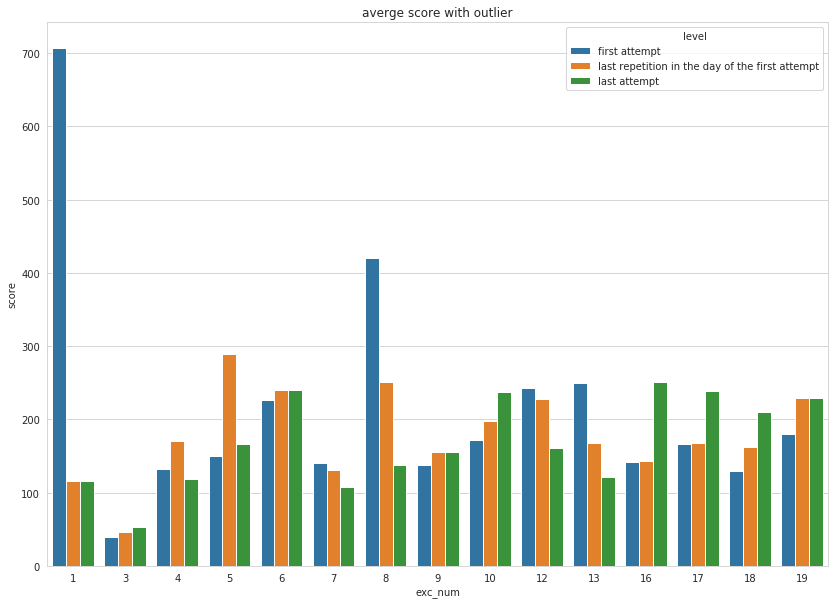

In [11]:
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.barplot(x="exc_num", y="score", hue='level', data=df_6_3,ci=0).set_title('averge score')

# Diagram 6.4 Whisker box 

In [12]:
df_6_4 = df[['day', 'exc_num', 'exc_times', 'uid', 'score']].groupby(['day', 'exc_num', 'exc_times', 'uid']).mean()
df_6_4 = df_6_4.reset_index()

first_attempt = df_6_4.groupby(['exc_num', 'uid']).head(1)
first_attempt = first_attempt.reset_index()

last_attempt = df_6_4.groupby(['exc_num', 'uid']).tail(1)
last_attempt = last_attempt.reset_index()

first_attempt['level'] = 'first attempt'
last_attempt['level'] = 'last attempt'

cols = ['uid', 'day', 'exc_num', 'level', 'score']
df_6_4 = pd.concat([first_attempt[cols], last_attempt[cols]])


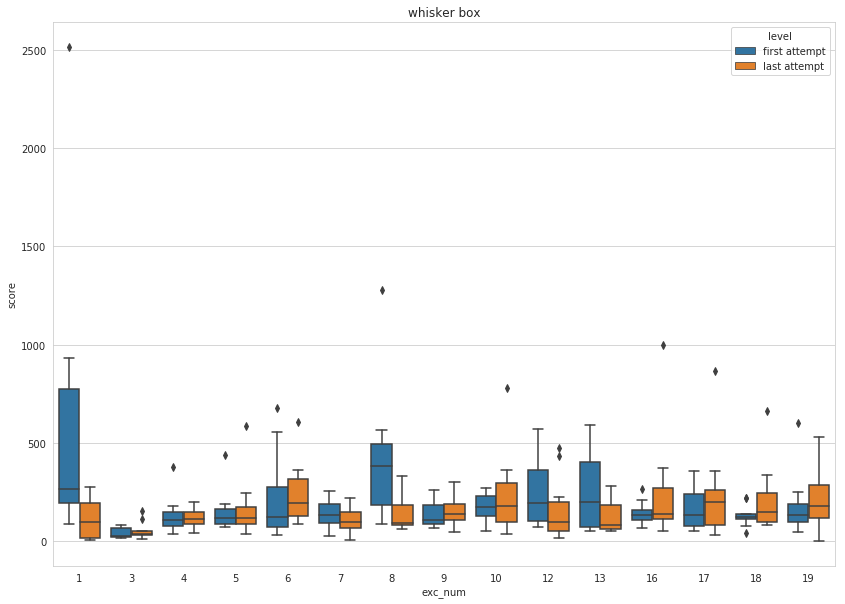

In [13]:
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="exc_num", y="score", hue='level', data=df_6_4).set_title('whisker box')

# Diagram 6.7 Correlation between score and time

In [16]:
df_score = df[['day', 'exc_num', 'exc_times', 'uid', 'score']].groupby(['day', 'exc_num', 'exc_times', 'uid']).mean()
df_score = df_score.reset_index()
df_score
df_time = pd.read_csv('../data/running_time.csv')
df_time = df_time.groupby(['uid', 'day', 'exc_num', 'exc_times']).sum()
df_time = df_time.reset_index()

df_6_7 = df_time.merge(df_score, on=['uid', 'day', 'exc_num', 'exc_times'], how='inner')
df_6_7 = df_6_7[['uid', 'running_time', 'score']]

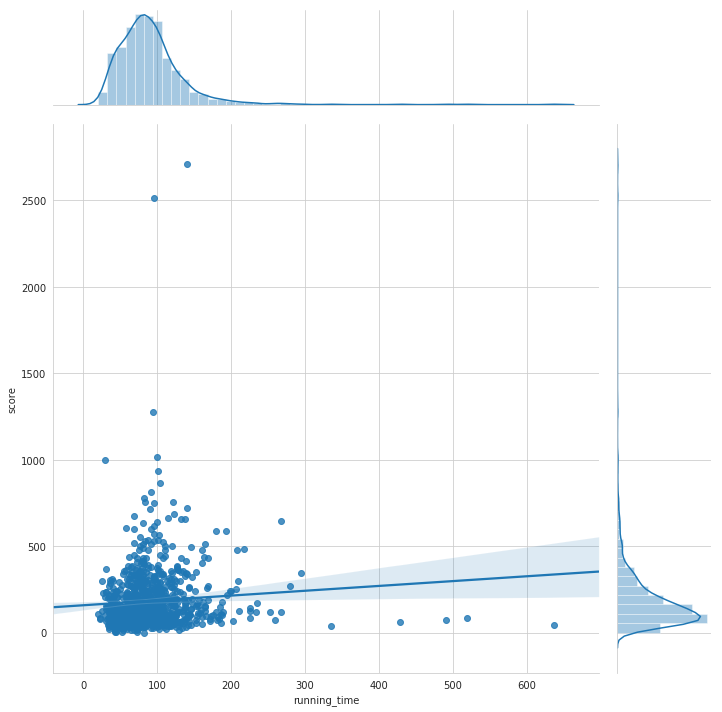

In [17]:
# sns.set_style('whitegrid')
# f, ax= plt.subplots(figsize = (14, 10))

# g  = sns.jointplot(x="running_time", y="score", data=df_6_7, kind="reg")
g = sns.JointGrid(x="running_time", y="score", data=df_6_7, height=10)
g = g.plot(sns.regplot, sns.distplot)